In [19]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
import joblib


In [3]:
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
df = pd.read_csv("../data/dataset_ready/features.csv")
print("✅ Dataset cargado:", df.shape)

# Features y etiquetas
X = df[['angle_knee_left', 'angle_knee_right', 'angle_hip_left', 'angle_hip_right',
        'trunk_inclination', 'shoulder_dist', 'hip_dist']]
y = df['label']

# Normalizar (opcional, pero mejora el entrenamiento)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
joblib.dump(scaler, "./models/scaler.pkl")
print("✅ Scaler guardado.")
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Tamaño de entrenamiento:", X_train.shape)
print("Tamaño de prueba:", X_test.shape)

# Convertir etiquetas a one-hot encoding (opcional, pero útil)

num_classes = len(df['label'].unique())
print("Número de clases:", num_classes)


✅ Dataset cargado: (13361, 9)
✅ Scaler guardado.
Tamaño de entrenamiento: (10688, 7)
Tamaño de prueba: (2673, 7)
Número de clases: 5


In [9]:
print(df['label'].nunique())

5


In [10]:
print(df['label'].value_counts())

label
3    3255
2    2980
1    2599
0    2302
4    2225
Name: count, dtype: int64


In [11]:
def build_model(hidden1=128, hidden2=64, hidden3=32, hidden4=16, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(hidden1, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden3, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden4, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

c:\Users\alejo\Documents\SEMESTRE VII\APO III\TI2\ti2-2025-1-e9-ds\venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,525 (45.02 KB)

 Trainable params: 11,525 (45.02 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model = KerasClassifier(model=build_model, epochs=30, batch_size=32, verbose=0)

# Definir hiperparámetros a probar
param_grid = {
    'model__hidden1': [64, 128],
    'model__hidden2': [32, 64],
    'model__hidden3': [16, 32],
    'model__hidden4': [8, 16],
    'model__dropout_rate': [0.2, 0.3],
    'model__learning_rate': [0.001, 0.0005],
    'batch_size': [16],
    'epochs': [30]
}
# Grid Search con 3-fold cross-validation
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='accuracy')

# Ejecutar la búsqueda
grid_result = grid.fit(X_scaled, y)

c:\Users\samue\Desktop\Samuel\Inteligencia_Artificial\Proyecto\Pose-activity-detector-\env\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
results_df = pd.DataFrame(grid_result.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
print(results_df[['mean_test_score', 'params']].head())

    mean_test_score                                             params
12         0.114661  {'batch_size': 16, 'epochs': 30, 'model__dropo...
42         0.113090  {'batch_size': 16, 'epochs': 30, 'model__dropo...
14         0.112338  {'batch_size': 16, 'epochs': 30, 'model__dropo...
22         0.111739  {'batch_size': 16, 'epochs': 30, 'model__dropo...
31         0.110320  {'batch_size': 16, 'epochs': 30, 'model__dropo...


In [17]:
print(f"✅ Mejor Accuracy: {grid_result.best_score_:.4f}")
print("🔧 Mejores hiperparámetros:", grid_result.best_params_)

✅ Mejor Accuracy: 0.1147
🔧 Mejores hiperparámetros: {'batch_size': 16, 'epochs': 30, 'model__dropout_rate': 0.2, 'model__hidden1': 64, 'model__hidden2': 64, 'model__hidden3': 32, 'model__hidden4': 8, 'model__learning_rate': 0.001}


In [22]:
best_model = grid_result.best_estimator_.model_
best_model.save("./models/mejor_modelo_movimiento.h5")

---
---

In [20]:
from tensorflow.keras.utils import to_categorical

In [21]:
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

In [27]:

model_after_cv = Sequential()
model_after_cv.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
model_after_cv.add(Dropout(0.2))
model_after_cv.add(Dense(64, activation='relu'))
model_after_cv.add(Dropout(0.2))
model_after_cv.add(Dense(32, activation='relu'))
model_after_cv.add(Dropout(0.2))
model_after_cv.add(Dense(8, activation='relu'))
model_after_cv.add(Dense(num_classes, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model_after_cv.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# # Definir modelo
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [30]:
history = model_after_cv.fit(X_train, y_train_cat, epochs=64, batch_size=16, validation_data=(X_test, y_test_cat))
model_after_cv.save("./models/Neural-Network_classifier.h5")
print("✅ Modelo guardado.")

Epoch 1/64
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6948 - loss: 0.7124 - val_accuracy: 0.7377 - val_loss: 0.5973
Epoch 2/64
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6972 - loss: 0.6901 - val_accuracy: 0.7299 - val_loss: 0.6033
Epoch 3/64
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6914 - loss: 0.7035 - val_accuracy: 0.7265 - val_loss: 0.6001
Epoch 4/64
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6851 - loss: 0.7013 - val_accuracy: 0.7344 - val_loss: 0.6104
Epoch 5/64
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6911 - loss: 0.7021 - val_accuracy: 0.7318 - val_loss: 0.5989
Epoch 6/64
668/668 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6872 - loss: 0.7077 - val_accuracy: 0.7359 - val_loss: 0.5956
Epoch 7/64
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6922 - loss: 0.7111 - val_accuracy: 0.7344 - val_loss: 0.5963
Epoch 8/64
668/668 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6962 - loss: 0.6861 - val_accuracy: 0.

✅ Modelo guardado.


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7394 - loss: 0.5897
🔍 Accuracy en prueba: 0.75


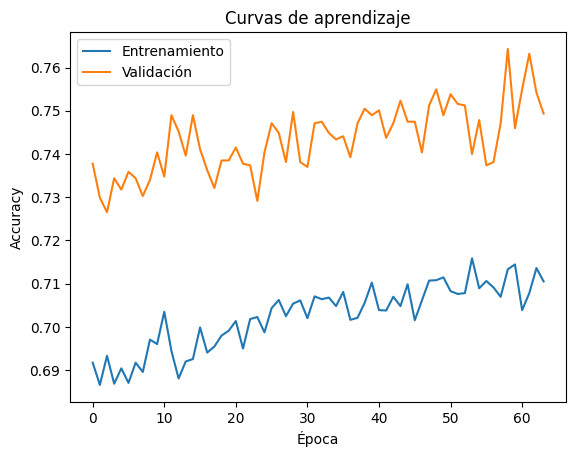

In [31]:
# Evaluar en el set de prueba
test_loss, test_acc = model_after_cv.evaluate(X_test, y_test_cat)
print(f"🔍 Accuracy en prueba: {test_acc:.2f}")

# Visualizar curvas de entrenamiento
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Curvas de aprendizaje')
plt.show()

In [7]:
# Cargar modelo
model = load_model("./models/movimiento_classifier.h5")

# Supongamos que tienes un nuevo vector de features:
new_features = np.array([[130, 125, 120, 115, 75, 0.05, 0.02]])
new_features_scaled = scaler.transform(new_features)

# Predicción
prediction = model.predict(new_features_scaled)
class_idx = np.argmax(prediction)
print("Predicción:", class_idx)

c:\Users\alejo\Documents\SEMESTRE VII\APO III\TI2\ti2-2025-1-e9-ds\venv\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
Predicción: 0
